# Part I: Should we launch the new product feature? 
Airbnb has a new product feature. A/B testing is undergoing.

**New product feature**:
* Require the guest to write a >= 140 character message to explain the interest in staying with the host

**Problem statement**: 
* Determine if the new product feature improves the booking rate (and it will be launched) or otherwise (and the experiment will be stopped). 

**A/B testing**:
* Treatment: Guests in the treatment group are required to write a message that is at least 140 characters long to explain the interest in staying with the host before proceeds.
* Control: Guests in the control group are not required of writing a message before proceeds. But the guest can always send a message to host.

The main steps are summarized below:
1. Understand the data. I will work with assign and contact data sets, and focus on data quality. 
2. Calculate booking rate for treatment and control groups. There are three ways to book on Aribnb. This problem is most concerned with how the message affects the booking rate. I will only consider contact me and book it as the message will influence the host's decision to accept the request/reservation or not. Instant booking will not be included as it has 100% booking rate, as you will seen in the data.  
3. Perform t test to compare the booking rate in the two groups. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
import statsmodels.api as sm
import datetime
from scipy import stats
%matplotlib inline

## 1. Load data
Let's first look at the assign and contact data set.

In [2]:
#load data sets
assign = pd.read_csv('assignments.csv')
contact = pd.read_csv('contacts.csv')

In [3]:
print assign.shape, contact.shape

(50000, 2) (50000, 13)


In [4]:
assign.head()

,id_user_anon,ab
0,96cdf536-88d2-436f-a6fb-86df9d4e4b4c,treatment
1,4bf312ae-3ca7-4abc-9d10-40975b2ec9b4,control
2,984a32d6-0cdd-4281-b8c2-4d604680d99a,control
3,732888ac-e357-4423-9cb5-f2cfbf4640f0,control
4,cb5e69e4-2f3c-46c9-a31a-d94277c4a727,treatment


In [5]:
contact.head(1)

,id_guest_anon,id_host_anon,id_listing_anon,ts_interaction_first,ts_reply_at_first,ts_accepted_at_first,ts_booking_at,ds_checkin_first,ds_checkout_first,m_guests_first,m_interactions,m_first_message_length_in_characters,dim_contact_channel_first
0,309179fa-fab8-4798-9426-93641321b003,71d784c7-95d2-4d49-9a4e-bd0662a72fd6,edbb8e3d-5281-4d1f-aef6-3a40ecaa208a,2013-01-01 01:48:57,2013-01-01 10:40:55.0,NaN,NaN,2013-01-02,2013-01-03,1.0,3,538.0,contact_me


## 2. Understand the data

### 1). Group assignment
First look at the assign data set. Things to check includes missing values, duplicates, outliers, and things that don't make sense(if any).

In [6]:
#missing values
assign.isnull().sum()

id_user_anon    0
ab              0
dtype: int64

No missing values. Let's check duplicates.

In [7]:
print "User number without duplicates are %d."%assign.drop_duplicates().shape[0]
print 'There are %d duplicates.'%(assign.shape[0] - assign.drop_duplicates().shape[0])

User number without duplicates are 31763.
There are 18237 duplicates.


Noticed that contact and assign data sets have the same row number, they might originate from the same table. This explains why we see duplicates in assign. Let's confirm it.

In [3]:
#check duplicates
#assign.groupby('id_user_anon').count().sort_values(by='ab',ascending=False)

#user frequency table
group_by_id = assign.groupby(['id_user_anon', 'ab']).size().unstack()
print group_by_id.head(10)

#user example
print assign[assign.id_user_anon == '000a0daf-6cbf-42ea-8ad2-9ff1caad1301']

ab                                    control  treatment
id_user_anon                                            
0005f1d2-acc7-4bf3-8da6-20674865d55b      1.0        NaN
0007b6a0-72e7-4be6-b459-7512cdaca8f1      1.0        1.0
00097089-015d-432f-b346-255e7f0d683f      3.0        2.0
000a0daf-6cbf-42ea-8ad2-9ff1caad1301      2.0        2.0
000a9b12-88e8-4d4b-ad52-a0ddea9f6e48      2.0        1.0
000b5b75-fe27-43bd-a757-51652ad0faed      NaN        2.0
000c5092-ff3e-404a-8b3c-dbcecaaa8343      NaN        2.0
000cd573-d56e-42a3-b1c0-beeea9939bd2      3.0        4.0
001575ef-f5cc-4f3c-aa2d-e28265a92a07      1.0        6.0
0016db29-ed54-49ed-bc5a-4883a1852c19      1.0        NaN
                               id_user_anon         ab
776    000a0daf-6cbf-42ea-8ad2-9ff1caad1301  treatment
26023  000a0daf-6cbf-42ea-8ad2-9ff1caad1301    control
32542  000a0daf-6cbf-42ea-8ad2-9ff1caad1301  treatment
47117  000a0daf-6cbf-42ea-8ad2-9ff1caad1301    control


In [9]:
#unique users
print "Unique user number is %d."%len(np.unique(assign.id_user_anon))
print 'There are %d users in both control and treatment group.' \
        %(assign.drop_duplicates().shape[0]-len(np.unique(assign.id_user_anon)))

Unique user number is 25209.
There are 6554 users in both control and treatment group.


A few things I noticed here:
1. There are duplicates. The same user is assigned to control or treatment multiple times. I will drop those duplicates. 
2. The same user is assigned to both treatment and control! 
 * This is not a good idea in A/B testing. The treatment to the user may affect his/her behavior in the control or vice versa. Say a guest is in treatment first. He is required to write a long message to the host. Then he is in the control group, and is not required to write the message. But he may still write one which he may not have written without the treatment. The guest behavior is changed by the treatment, causing bias to the experiment. 
 * To ensure the experiment accuracy, I will drop these users. 
 * Reasons causing the double-counting. User must sign in to make inquiries, so we can exclude the mixed group effect caused by cookie assignment. There might be procedural errors. Data science team should talk to the engineering team and find the root cause.

I will drop duplicates and users in both groups.

In [4]:
#drop duplicates
assign = assign.drop_duplicates()
#assign.shape

In [5]:
#drop users in both groups
mixed_grouped = assign.groupby(['id_user_anon']).count()
tokeep = mixed_grouped[mixed_grouped.ab == 1].reset_index().id_user_anon.tolist()
assign = assign[assign.id_user_anon.isin(tokeep)]

In [6]:
#users
assign.shape

(18655, 2)

### 2). Understand contacts between guest and host
Now I will focus on contact data set.

#### A. Check missing values

In [13]:
#check missing values
contact.isnull().sum()

id_guest_anon                               0
id_host_anon                                0
id_listing_anon                             0
ts_interaction_first                        0
ts_reply_at_first                        5925
ts_accepted_at_first                    26807
ts_booking_at                           37593
ds_checkin_first                            0
ds_checkout_first                           0
m_guests_first                            145
m_interactions                              0
m_first_message_length_in_characters        0
dim_contact_channel_first                   0
dtype: int64

The missing values in ts_reply_at_first, ts_accepted_at_first, and ts_booking_at means that the host did not reply, did not accept the booking, and the booking was not successful (due to either host not accepting or guest canceling it). They will be used for booking rate or accepting rate calculation. I will not drop them. The missing values in m_guests_first is likely because the guest didn't put in the information. I will take care of it later.

#### B. Number of guest-host interactions

In [14]:
#distribution
contact.m_interactions.describe()

count    50000.000000
mean         5.354240
std          5.646864
min          1.000000
25%          2.000000
50%          3.000000
75%          7.000000
max        164.000000
Name: m_interactions, dtype: float64

164 interactions look suspicious. I will take a closer look.

In [15]:
contact[contact.m_interactions ==  164]

,id_guest_anon,id_host_anon,id_listing_anon,ts_interaction_first,ts_reply_at_first,ts_accepted_at_first,ts_booking_at,ds_checkin_first,ds_checkout_first,m_guests_first,m_interactions,m_first_message_length_in_characters,dim_contact_channel_first
40069,6569deb9-71dd-4915-89dc-d2310a42da40,f24fcf08-6f76-4b2b-8481-2f51a969a518,73470500-2c49-4066-a9ff-f46dcd70ea8f,2013-09-04 07:29:22,2013-09-04 08:19:37.0,2014-08-06 20:22:52.0,NaN,2013-11-20,2013-11-24,1.0,164,92.0,contact_me


This data is indeed suspicious:
1. The number of interactions between guest and host is 164, which is abnormally high.
2. The host accepted the booking request almost a year later of the first inquiry. 

Considering how representative the data is, I will remove this data point.

In [7]:
contact = contact[contact.m_interactions != 164]

In [17]:
#check high interaction listings
contact[contact.m_interactions > 50]

,id_guest_anon,id_host_anon,id_listing_anon,ts_interaction_first,ts_reply_at_first,ts_accepted_at_first,ts_booking_at,ds_checkin_first,ds_checkout_first,m_guests_first,m_interactions,m_first_message_length_in_characters,dim_contact_channel_first
1186,5cce0b86-d257-4d1a-b52a-c95e98c1d8e9,6fcd10bc-65aa-4932-8268-23711fa13103,8f7b0d9b-1bd0-4826-bb0f-4cb3b389811b,2013-05-07 00:20:08,2013-05-07 05:19:29.0,2013-05-18 23:59:17.0,2013-05-18 23:59:17.0,2013-08-20,2013-08-23,2.0,54,319.0,contact_me
1404,95585217-871c-4eac-a8d4-47a87b9a9314,3b93f529-40ba-457b-aef3-326838df16fc,f475c8d5-4dc5-43bc-ae50-f7a3d505919d,2013-05-25 11:10:18,2013-05-25 12:36:40.0,2013-05-27 07:03:24.0,2013-05-31 07:43:39.0,2013-06-06,2013-06-09,1.0,107,289.0,contact_me
2777,af683d82-92fa-4f91-a06d-2abaca856a23,9dae91a9-9a73-4fb7-9b47-a0bd9cf69a86,a75c66c9-565c-4c57-bcbf-ad48e29fb7ec,2013-09-13 12:13:12,2013-09-13 12:28:45.0,2013-09-13 12:28:45.0,2013-09-19 17:07:42.0,2013-11-05,2013-11-11,2.0,68,59.0,contact_me
3204,a14bd4c6-384a-4775-beca-a6427ab5bea8,89a37380-965c-4822-b9de-69a594aadc96,d5be9e7f-b74c-40ff-99a0-cac88416645f,2013-10-08 20:54:34,2013-10-08 21:36:35.0,2013-10-09 08:17:56.0,2013-10-13 22:28:05.0,2014-01-06,2014-02-05,1.0,55,174.0,contact_me
4306,c214000d-c6c1-4c17-b20c-70e8cc40f087,82d04f57-2a24-4751-a6c7-2e9168b66822,ded16fc8-2ddb-4c4e-b531-4719364505bb,2013-12-17 19:27:51,2013-12-17 21:33:06.0,2013-12-18 21:45:07.0,2013-12-21 15:40:37.0,2014-01-01,2014-01-08,1.0,83,248.0,contact_me
5711,7744c449-a3eb-4fc0-a275-02805ca5a322,d4b63087-0a82-4fc7-81e0-6d299ec9837f,f473e902-0f7c-4b02-adce-64b20650e1a2,2013-02-08 18:21:02,2013-02-08 18:40:10.0,2013-02-08 18:40:10.0,2013-02-14 19:14:58.0,2013-02-18,2013-03-18,1.0,53,158.0,contact_me
7094,4225e82b-5334-46f2-bd82-dec4f27e6bba,39008088-58f6-43f7-9b3a-5c122a5253de,984c3c8b-a220-4ece-9020-4ca327500c12,2013-06-18 17:49:43,2013-06-19 06:41:37.0,2013-06-20 14:07:18.0,2013-06-21 10:36:18.0,2013-06-19,2013-09-14,1.0,71,321.0,contact_me
8849,59fc76e2-dd51-4ad9-90ac-45e3c57b337b,831e7814-c85c-4372-ba5b-9d3361e5d00e,6a352d61-4956-431b-8eff-f3b093d8b177,2013-10-30 20:08:45,2013-10-30 20:21:13.0,2013-10-30 20:21:13.0,2013-10-30 20:40:34.0,2013-11-27,2014-01-01,2.0,52,179.0,contact_me
9097,2b248f34-7b96-4316-bcfa-c5e8ae9b8217,85bfd501-4dec-4ed8-93fe-6b1caa45ec52,269e6a86-62d9-4fb2-bf78-dae33f2f0b04,2013-11-16 20:37:40,2013-11-16 20:58:26.0,2013-11-16 20:58:26.0,2013-12-28 17:43:52.0,2014-06-08,2014-07-18,3.0,93,1076.0,contact_me
12320,a813f973-12ee-4e1a-b0e7-c42eebe381d5,8748f084-0761-447e-9a65-d567f3a07dde,75df1f31-b8c6-4a83-a2a3-9d9e63557af9,2013-06-14 07:21:22,2013-06-16 07:55:29.0,2013-06-17 05:07:44.0,2013-06-17 05:07:44.0,2013-07-20,2013-07-23,6.0,52,188.0,contact_me


Browsing through the contact with high guest-host interactions, no obvious abnormalies were found. Noted that high number of interactions tend to have high booking rate. This will help the second part of the challenge.

#### C. First message length

In [8]:
#distribution
contact.m_first_message_length_in_characters.describe()

count    49999.000000
mean       285.153123
std        190.848521
min          0.000000
25%        172.000000
50%        239.000000
75%        356.000000
max       2751.000000
Name: m_first_message_length_in_characters, dtype: float64

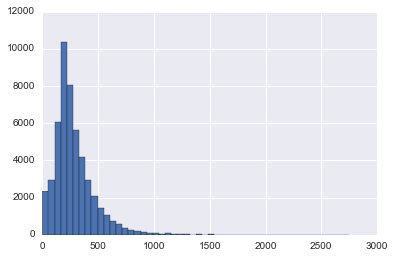

In [19]:
#histgram
contact.m_first_message_length_in_characters.hist(bins=50)

The longest message has 2751 characters. That looks suspicious. Let's take a closer look.

In [20]:
contact[contact.m_first_message_length_in_characters == 2751]

,id_guest_anon,id_host_anon,id_listing_anon,ts_interaction_first,ts_reply_at_first,ts_accepted_at_first,ts_booking_at,ds_checkin_first,ds_checkout_first,m_guests_first,m_interactions,m_first_message_length_in_characters,dim_contact_channel_first
47151,d7a6ce12-8bef-4cb4-8225-0610bcaac91f,ef706a92-75ef-425b-bb0b-f1540986b3e0,90f9988e-5c1b-4303-9d15-19fdff2ced76,2013-12-27 13:43:29,2013-12-27 21:05:05.0,2013-12-27 21:05:05.0,NaN,2014-02-01,2014-02-22,1.0,2,2751.0,contact_me


The guest wrote a long message to the host. The host accepted the booking request. But the guest end up canceling the booking. Let's check if the guest has made other requests.  

In [21]:
contact[contact.id_guest_anon == 'd7a6ce12-8bef-4cb4-8225-0610bcaac91f']

,id_guest_anon,id_host_anon,id_listing_anon,ts_interaction_first,ts_reply_at_first,ts_accepted_at_first,ts_booking_at,ds_checkin_first,ds_checkout_first,m_guests_first,m_interactions,m_first_message_length_in_characters,dim_contact_channel_first
41782,d7a6ce12-8bef-4cb4-8225-0610bcaac91f,7e58b421-8d94-4d47-9a6f-fcee736ba38c,f590d81e-db3c-4c56-8b50-13ae7dc0e0da,2013-12-27 13:44:19,2013-12-29 17:53:26.0,NaN,NaN,2014-02-01,2014-02-22,1.0,6,2746.0,contact_me
47151,d7a6ce12-8bef-4cb4-8225-0610bcaac91f,ef706a92-75ef-425b-bb0b-f1540986b3e0,90f9988e-5c1b-4303-9d15-19fdff2ced76,2013-12-27 13:43:29,2013-12-27 21:05:05.0,2013-12-27 21:05:05.0,NaN,2014-02-01,2014-02-22,1.0,2,2751.0,contact_me


The guest did make another booking request at almost the same time with another host and a 2746 characters' message. Unfortunately, the host didn't accept his/her request. OK. The long message is consistent. This might be his/her way of doing this. I will keep the data.

#### D. First contact channel

In [22]:
#distribution
contact.dim_contact_channel_first.value_counts()

contact_me        41008
book_it            7719
instant_booked     1272
Name: dim_contact_channel_first, dtype: int64

Majority booking requests are sent through contact me method, followed by book it and instant book. Let's look at the first message length.

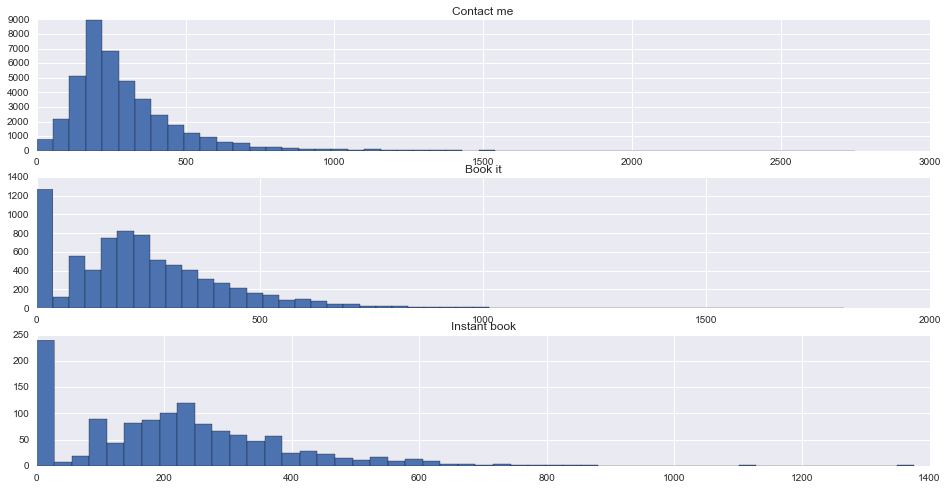

In [23]:
#plot booking method vs first message length
fig, ax = plt.subplots(3, figsize=(16,8))
contact[contact.dim_contact_channel_first == 'contact_me']['m_first_message_length_in_characters'].hist(bins=50, ax=ax[0])
ax[0].set_title('Contact me')
contact[contact.dim_contact_channel_first == 'book_it']['m_first_message_length_in_characters'].hist(bins=50, ax=ax[1])
ax[1].set_title('Book it')
contact[contact.dim_contact_channel_first == 'instant_booked']['m_first_message_length_in_characters'].hist(bins=50, ax=ax[2])
ax[2].set_title('Instant book')

Contact me has the longest message in general. Many guest don't write a message when using instant book, which makes sense. Through book it, guests do write messages with various length. It suggests that it's more meaningful to study the message effect on booking rate in contact me and book it.  

#### D.  Guest inquiry time, host reply time, host accept time, booking time

In [24]:
#group by guest, host and listing
group_by_contact = contact.groupby(['id_guest_anon', 'id_host_anon', 'id_listing_anon'])\
                                                                [['ts_booking_at']].count()

In [109]:
#multiple booking with the same listing
#group_by_contact[group_by_contact.ts_booking_at > 1]

In [26]:
contact[contact.id_guest_anon == '040b25bd-7eb0-4490-ab01-ef955c3beedf']

,id_guest_anon,id_host_anon,id_listing_anon,ts_interaction_first,ts_reply_at_first,ts_accepted_at_first,ts_booking_at,ds_checkin_first,ds_checkout_first,m_guests_first,m_interactions,m_first_message_length_in_characters,dim_contact_channel_first
4678,040b25bd-7eb0-4490-ab01-ef955c3beedf,83651995-613a-4941-95b0-6e9f51bbdc30,4b7a144a-b0b2-4749-ad72-cdecd8d37afb,2013-04-21 20:30:01,2013-04-21 20:28:21.0,2013-04-21 20:28:21.0,2013-04-21 20:28:21.0,2013-06-02,2013-06-09,2.0,2,183.0,instant_booked
26034,040b25bd-7eb0-4490-ab01-ef955c3beedf,83651995-613a-4941-95b0-6e9f51bbdc30,4b7a144a-b0b2-4749-ad72-cdecd8d37afb,2013-04-21 20:34:47,2013-04-21 20:33:07.0,2013-04-21 20:33:07.0,2013-04-21 20:33:07.0,2013-06-17,2013-06-23,2.0,7,99.0,instant_booked


A few findings here:
1. The guest made two bookings with the same host at different check-in. This should not be considered as duplicates.
2. Hosts can pre-approve the request. This is seen when hosts reply and accept booking at the same time. 
3. There are some data issues. The host replies even before the guest's inquiry. Doesn't make sense. This might be some mistakes in the loggings. We should communicate this to the engineering team. To ensure data quality, I will remove those data points.

In [9]:
#convert to date type
contact['ts_interaction_first'] = pd.to_datetime(contact.ts_interaction_first, format='%Y-%m-%d %H:%M:%S')
contact['ts_reply_at_first'] = pd.to_datetime(contact.ts_reply_at_first, format='%Y-%m-%d %H:%M:%S')
contact['ts_accepted_at_first'] = pd.to_datetime(contact.ts_accepted_at_first, format='%Y-%m-%d %H:%M:%S')
contact['ts_booking_at'] = pd.to_datetime(contact.ts_booking_at, format='%Y-%m-%d %H:%M:%S')
contact['ds_checkin_first'] = pd.to_datetime(contact.ds_checkin_first, format='%Y-%m-%d %H:%M:%S')

#contact['delay_reply_hour'] = (contact.ts_reply_at_first - contact.ts_interaction_first)\
                                    #.apply(lambda x: x.seconds/3600. if not pd.isnull(x) else None)
contact['delay_reply_nday'] = (contact.ts_reply_at_first - contact.ts_interaction_first)\
                                    .apply(lambda x: x.days if not pd.isnull(x) else None)
contact['delay_checkin_nday'] = (contact.ds_checkin_first - contact.ts_interaction_first)\
                                    .apply(lambda x: x.days if not pd.isnull(x) else None)

#contact[contact['delay_reply_nday']<0].head()
#contact[contact['delay_checkin_nday'] < -1]
#contact['reply_delay_days'] = (pd.to_datetime(contact.ts_reply_at_first)\
                    #-pd.to_datetime(contact.ts_interaction_first))/np.timedelta64(1,'D')

In [10]:
print "Host replies before the inquiry: %d" %contact[contact['delay_reply_nday'] < 0].shape[0]
print "Check in before inquiry: %d "% contact[contact['delay_checkin_nday'] < -1].shape[0]

Host replies before the inquiry: 2254
Check in before inquiry: 22 


In [16]:
#remove these points
contact = contact[~(contact['delay_reply_nday'] < 0)]
contact.shape

(47734, 15)

In [18]:
contact[contact.delay_checkin_nday < -1].shape

(0, 15)

In [17]:
contact = contact[~(contact['delay_checkin_nday'] < -1)]
contact.shape

(47734, 15)

Given more time, I'd also like to examine the data quality between reply and accept time & between accept and booking time. Glancing through it, no obverious abnormalies were found. For check-in and check-out time, I believe the system is desigend to ensure the quality (meaning check out time is always after check in time). For the time constraint, I will not detail here. 

## 3. A/B testing

Now the data are clean and understood. Let's compare the booking rate for treatment and control groups. First I left join the contact and assign data sets by user id.

In [19]:
#left join contact and assign data sets
contact_assign = pd.merge(contact, assign, left_on='id_guest_anon', right_on='id_user_anon', \
                                                              how='left')
contact_assign.shape

(47734, 17)

The merged table has the same row nubmer as contact, as expected. 
The main point of the experiment is to see the required personal message help improve booking rate. Considering this, I will only include data in two channels: contact me and book it. In instant booking, the host auto-accepts the booking. This is out of the scope of the experiment. In contact me and book it method, personal message could have an impact on host preference. 

In [21]:
#only look at contact me and book it
test = pd.concat([contact_assign[contact_assign.dim_contact_channel_first == 'contact_me'], \
                  contact_assign[contact_assign.dim_contact_channel_first == 'book_it']])
test.shape

(47682, 17)

Now, let's calculate the booking rate in both treatment and control.

In [22]:
#make a column for booking rate
test['converted'] = test['ts_booking_at'].apply(lambda x: 0 if pd.isnull(x) else 1)
test.converted.value_counts()

0    36801
1    10881
Name: converted, dtype: int64

In [23]:
#separate treatment and control groups
treatment = test[test.ab == 'treatment']
control = test[test.ab == 'control']
print "Treatment group has a sample size of %d." % treatment.shape[0]
print "Control group has a sample sie of %d." % control.shape[0]

Treatment group has a sample size of 10527.
Control group has a sample sie of 10477.


The groups are blanced. Then I will perform t test to compare the mean.

In [32]:
X = control.converted
Y = treatment.converted

#mean
print "Control group has an averaged booking rate of %2f." % X.mean()
print "Treatment group has an averaged booking rate of %2f." % Y.mean()

Control group has an averaged booking rate of 0.379880.
Treatment group has an averaged booking rate of 0.378645.


We can see that the booking rate are similar between the treatment and control. This is expected. Many guests in control group write messages to host. Now let's run t test to compare the mean booking rate.

In [41]:
#f test to see if equal var
def F_test(X, Y, alpha):
    alpha = alpha
    F = np.var(X) / np.var(Y)
    df1 = len(X) - 1
    df2 = len(Y) - 1
    p_value = stats.f.cdf(F, df1, df2)
  
    if p_value > alpha:
        return True
    else:
        return False

alpha = 0.05
var_equal = F_test(X, Y, alpha)
print 'At a %d%% confidence level, does the two population have an equal variance? %s' % ((1-alpha)*100, var_equal)

At a 95% confidence level, does the two population have an equal variance? True


In [42]:
#student t test to compare mean
def T_test(X, Y, alpha):
    alpha = alpha
    p_value = stats.ttest_ind(a=X, b=Y, equal_var=True)
  
    if p_value > alpha:
        return True
    else:
        return False

alpha = 0.05
mean_equal = T_test(X, Y, alpha)
print 'At a %d%% confidence level, does the two population have an equal variance? %s' % ((1-alpha)*100, mean_equal)

At a 95% confidence level, does the two population have an equal variance? True


At a 95% confidence level, the booking rate are the same between treatment and control group. I also did a quick power analysis. With an effect size of 5%, a power of 80% and significant of 5%, the sample size is sufficient to conclude. As a result, I recommend stopping the experiment.

# Part II: Booking rate prediction

To predict the booking rate, below are my hypotheses:
1. Contact channel. The less processes, the higher booking rate. Booking rate: instant book > book it > contact me. 
2. Check in time - seasonality. Summer is usually a busy season. Multiple guests try to book from the same host. The host can't accept all the bookings. Perhaps first come first serve.
3. How early do you book the trip? This is the time difference between first inquiry and check in time. The sooner you make the inquiry, the more available the rooms are.
4. The number of interactions between guests and hosts. More interactions means both guests and hosts are more enaged.
5. How soon the host replies or accept inquires.
6. The nubmer of guests <= the room capacity. Host may reject your inquiry if not satisfied.
7. The time of the day the inquiry was sent. AM vs PM vs night.
8. The time of the week the inquiry was sent. Week day vs weekends.
9. Listings: The number of reveiws of the host, bathroom number, room type.
10. others

## 1. Exploring hypotheses

### 1). Contact channel

In [37]:
#add converted column
contact['converted'] = contact['ts_booking_at'].apply(lambda x: 0 if pd.isnull(x) else 1)

#contact channel frequency table
group_by_channel = contact.groupby(['dim_contact_channel_first', 'converted']).size().unstack()
group_by_channel.columns = ['unconverted', 'converted']
group_by_channel = group_by_channel.fillna(0)

group_by_channel['booking_rate'] = group_by_channel['converted'] / \
(group_by_channel['unconverted'] + group_by_channel['converted'])
print group_by_channel

                           unconverted  converted  booking_rate
dim_contact_channel_first                                      
book_it                         2474.0     5242.0      0.679368
contact_me                     35100.0     5890.0      0.143694
instant_booked                     0.0     1271.0      1.000000


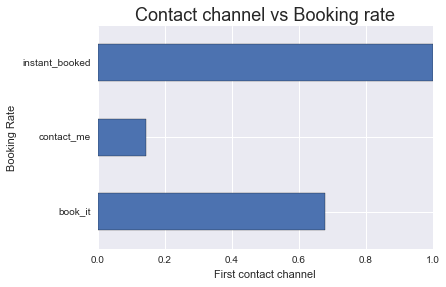

In [38]:
group_by_channel.booking_rate.plot(kind='barh')
plt.xlabel('First contact channel')
plt.title('Contact channel vs Booking rate', fontsize=18)

My hypothesis is confirmed by the plot. The booking rate follows the order: instant booked (100%) > booked it (67.6%) > contact me (14.3%). Longer wait time likely loose the guest. I would also recommend always providing instant booked and book it options to hosts. If host happen to accept them, booking rate will also benefit.

## 2). Check-in time (Seasonality)

In [39]:
#seasonality by month
contact['checkin_month']  = contact.ds_checkin_first.apply(lambda x: x.month)

In [40]:
group_by_month = contact.groupby('checkin_month')['converted'].mean()
#group_by_month_err = contact.groupby('checkin_month')['converted'].std()

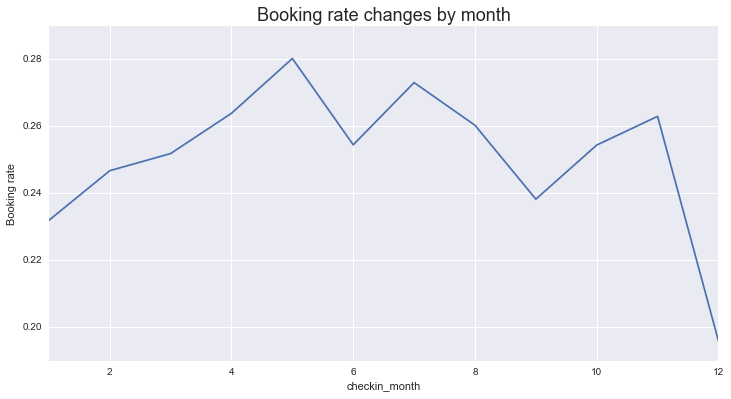

In [41]:
#plot booking rate change as month
group_by_month.plot(figsize=(12, 6))
plt.ylabel('Booking rate')
plt.title('Booking rate changes by month', fontsize=18)

### 3). How early do you book the trip?

In [42]:
#create a column to record the day difference between inquiry and check in 
contact['inquiry_checkin'] = (contact.ds_checkin_first - contact.ts_interaction_first).apply(lambda x: x.days)

In [43]:
#look at the stats
contact.inquiry_checkin.describe()

count    49977.000000
mean        35.409708
std         48.435652
min         -1.000000
25%          5.000000
50%         20.000000
75%         47.000000
max       1377.000000
Name: inquiry_checkin, dtype: float64

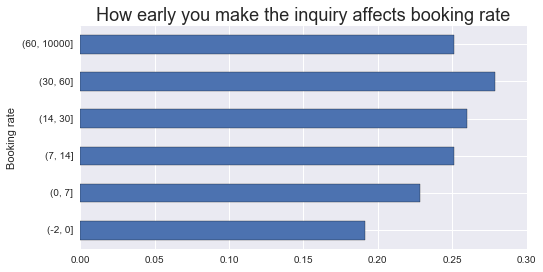

In [44]:
#plot booking rate variation with inquiry-check in time difference
bins=[-2, 0, 7, 14, 30, 60, 10000]
contact['inquiry_checkin_cat'] = pd.cut(contact.inquiry_checkin, bins=bins)

group_by_inquiry_checkin = contact.groupby('inquiry_checkin_cat')['converted'].mean()
group_by_inquiry_checkin.plot(kind='barh', figsize=(8, 4))
plt.xlabel('Booking rate')
plt.title('How early you make the inquiry affects booking rate', fontsize=18)

As above, the earlier the guest send the inquiry, the higher the booking rate. The drop after 100 days may be due to noise (not sufficient samples). I will consodiate the groups.

In [45]:
#consolidate the groups
labels = ['inquiry_same_day', 'inquiry_1_week_advance', 'inquiry_2_week_advance', \
          'inquiry_2_week_more_advance']
bins=[-2, 0, 7, 14, 10000]
contact['inquiry_checkin_cat'] = pd.cut(contact.inquiry_checkin, bins=bins, labels=labels)

In [46]:
#confirm the groups
contact.inquiry_checkin_cat.value_counts()

inquiry_2_week_more_advance    28914
inquiry_1_week_advance         10813
inquiry_2_week_advance          5952
inquiry_same_day                4298
Name: inquiry_checkin_cat, dtype: int64

### 4). Guest-host interactions

In [47]:
#separte interaction number to different groups
bins=[0, 2, 4, 6, 10, 20, 30, 40, 50, 60, 10000]
contact['num_interactions_cat'] = pd.cut(contact.m_interactions, bins=bins)

#group by the number of interactions
group_by_interactions = contact.groupby('num_interactions_cat')['converted'].mean()

In [48]:
contact.m_interactions.describe()

count    49977.000000
mean         5.352022
std          5.602091
min          1.000000
25%          2.000000
50%          3.000000
75%          7.000000
max        107.000000
Name: m_interactions, dtype: float64

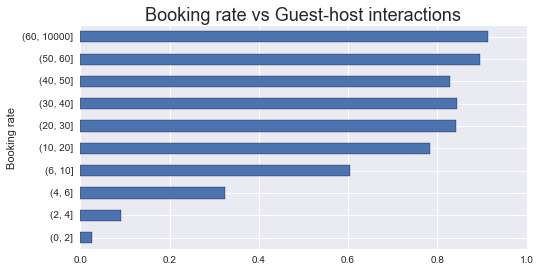

In [49]:
#plot booking rate change as interactions
group_by_interactions.plot(kind='barh', figsize=(8, 4))
plt.ylabel('Booking rate')
plt.title('Booking rate vs Guest-host interactions', fontsize=18)

The more guests and hosts interact, the higher the booking rate. The variation drops after 10 interactions. I will consolidate the groups.

In [50]:
#consolidate 
labels = ['interaction_0_2', 'interaction_2_4', 'interaction_4_6', 'interaction_6_10', 'interaction_10']
bins=[0, 2, 4, 6, 10, 10000]
contact['num_interactions_cat'] = pd.cut(contact.m_interactions, bins=bins, labels=labels)

In [51]:
#confirm the groups
contact.num_interactions_cat.value_counts()

interaction_0_2     18860
interaction_2_4     12623
interaction_10       6375
interaction_6_10     6355
interaction_4_6      5764
Name: num_interactions_cat, dtype: int64

### 5). How soon the host replies inquires.

In [52]:
#look at stats
contact.delay_reply_nday.describe()

count    44056.000000
mean         1.131333
std         19.184353
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       1136.000000
Name: delay_reply_nday, dtype: float64

In [53]:
#contact.delay_reply_nday.isnull().sum()

#find the mode
contact.delay_reply_nday.value_counts().head()

 0.0    37470
-1.0     2243
 1.0     1927
 2.0      800
 3.0      357
Name: delay_reply_nday, dtype: int64

In [54]:
#for simplicity, fill missing values with the mode
contact.delay_reply_nday.fillna(0, inplace=True)

In [55]:
bins=[-1, 1, 10000]
labels = ['host_reply_same_day', 'host_reply_after_inquiry_day']
contact['inquiry_reply_cat'] = pd.cut(contact.delay_reply_nday, bins=bins, labels=labels)

In [56]:
#contact.inquiry_reply_cat.isnull().sum()
#contact.inquiry_reply_cat.value_counts()
#contact.inquiry_reply_cat.fillna('host_reply_same_day', inplace=True)

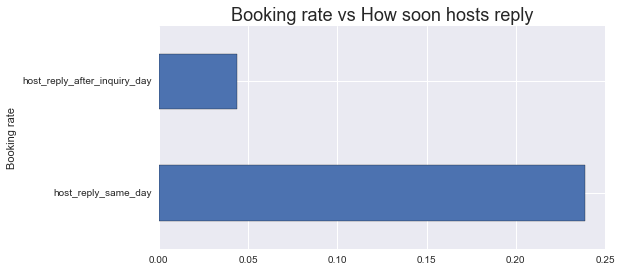

In [57]:
group_by_inquiry_reply = contact.groupby('inquiry_reply_cat')['converted'].mean()

group_by_inquiry_reply.plot(kind='barh', figsize=(8, 4))
plt.ylabel('Booking rate')
plt.title('Booking rate vs How soon hosts reply', fontsize=18)

The sooner the host replies, the higher the booking rate. If the host can reply the inquiry within one day, the chance of booking siginificant increases.

### 6). Does the nubmer of guests smaller than the room capacity?
Host may reject your inquiry if not satisfied. I need to merge contact and listing data set for the analysis.

In [58]:
#load listing data set
listing = pd.read_csv('listings.csv')

In [59]:
listing.shape

(5215, 5)

In [60]:
#check missing values
listing.isnull().sum()

id_listing_anon          0
dim_room_type            0
dim_person_capacity      0
dim_bathrooms          554
dim_total_reviews        0
dtype: int64

In [61]:
#merge contact and listing data sets
contact_listing = pd.merge(contact, listing, on='id_listing_anon', how='left')
contact_listing.shape

(49977, 25)

In [62]:
#check missing values
contact_listing.m_guests_first.isnull().sum()

145

In [63]:
contact_listing.m_guests_first.value_counts()

2.0     20738
1.0     15707
4.0      4707
3.0      4617
5.0      1713
6.0      1179
7.0       397
8.0       380
10.0      133
9.0       111
12.0       71
11.0       40
16.0       21
14.0        9
15.0        5
13.0        4
Name: m_guests_first, dtype: int64

In [64]:
#fill the missing value with the mode
contact_listing.m_guests_first.fillna(2, inplace=True)

In [65]:
#create column enough_capacity
contact_listing['enough_capacity'] = np.where(contact_listing['dim_person_capacity'] \
                                                  > contact_listing.m_guests_first, 1, 0)

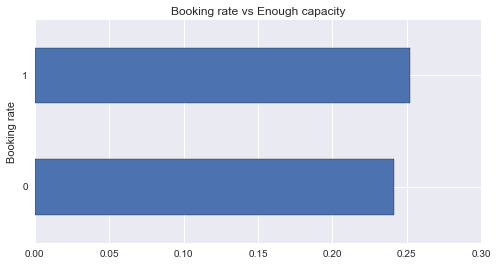

In [66]:
#plot booking rate change
group_by_enough_capacity = contact_listing.groupby('enough_capacity')['converted'].mean()
group_by_enough_capacity.plot(kind='barh', figsize=(8, 4),title='Booking rate vs Enough capacity')
plt.ylabel('Booking rate')

There is little improvement when room capacity is met. 

### 7). Listings
Room type, the number of reveiws of the host, bathroom number. 

In [67]:
#distribution
listing.dim_room_type.value_counts()

Entire home/apt    3042
Private room       2090
Shared room          83
Name: dim_room_type, dtype: int64

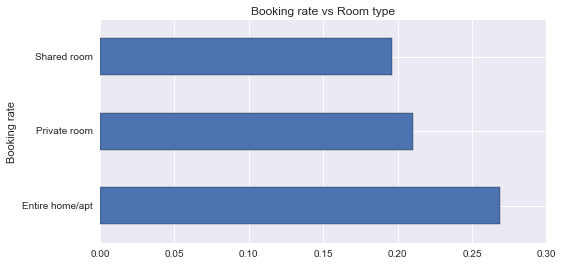

In [68]:
#plot booking rate change as room type
group_by_room_type = contact_listing.groupby('dim_room_type')['converted'].mean()
group_by_room_type.plot(kind='barh', figsize=(8, 4),title='Booking rate vs Room type')
plt.ylabel('Booking rate')

Renting the entire home tend to have a higher booking rate. But not a strong predictor. Then let's look at review numbers.

In [69]:
#distribution
listing.dim_total_reviews.describe()

count    5215.000000
mean       11.140748
std        22.993556
min         0.000000
25%         0.000000
50%         2.000000
75%        10.000000
max       321.000000
Name: dim_total_reviews, dtype: float64

In [70]:
listing.dim_total_reviews.isnull().sum()

0

Most hosts have zero reviews.

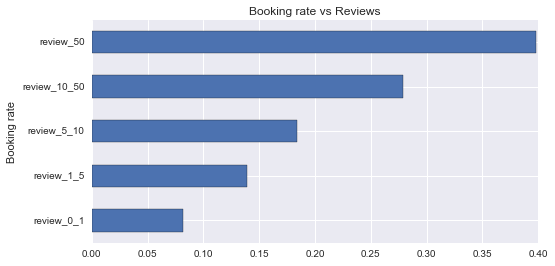

In [71]:
#create review category
bins=[0, 1, 5, 10, 50, 1000]
labels = ['review_0_1', 'review_1_5', 'review_5_10', 'review_10_50', 'review_50']
contact_listing['review_cat'] = pd.cut(contact_listing.dim_total_reviews, bins=bins, labels=labels)

group_by_review = contact_listing.groupby('review_cat')['converted'].mean()

#plot booking rate change as reviews
group_by_review.plot(kind='barh', figsize=(8, 4), title='Booking rate vs Reviews')
plt.ylabel('Booking rate')

Guests prefers hosts with higher reviews. Review number has a high predict power. Now let's check bathroom numbers.

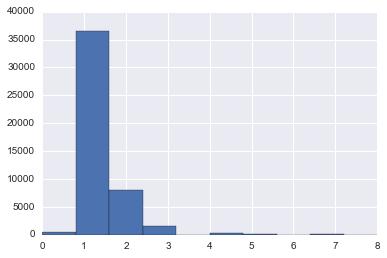

In [72]:
#distribution
contact_listing.dim_bathrooms.hist()

In [73]:
contact_listing.dim_bathrooms.value_counts()

1.0    35178
2.0     8010
3.0     1349
1.5     1307
4.0      340
0.0      312
2.5      292
0.5      182
5.0      144
7.0       67
4.5       21
6.0       12
3.5        9
8.0        8
5.5        3
Name: dim_bathrooms, dtype: int64

In [74]:
#missing values
contact_listing.dim_bathrooms.isnull().sum()

2743

In [75]:
#fill missing values with the mode
contact_listing.dim_bathrooms.fillna(1, inplace=True)
#contact_listing.dim_bathrooms.isnull().sum()

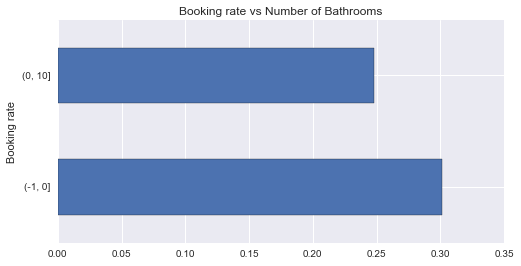

In [76]:
#bins=[-1, 0, 1, 1.5, 2, 3, 4, 5, 10]
bins=[-1, 0, 10]
contact_listing['bathroom_cat'] = pd.cut(contact_listing.dim_bathrooms, bins=bins)

group_by_bathroom = contact_listing.groupby('bathroom_cat')['converted'].mean()

#plot booking rate change as bathroom numbers
group_by_bathroom.plot(kind='barh', figsize=(8, 4), title='Booking rate vs Number of Bathrooms')
plt.ylabel('Booking rate')

As a guest, I really care about if the room has a bathroom or not. So the figure shows the comparison. But I don't see no bathroom hurts the booking rate. Perhaps the guest shares the bathroom and the room is cheaper. 

In [77]:
#bins=[-1, 5, 100]
#labels = ['bathroom_0_5', 'bathroom_5']
#contact_listing['bathroom_cat'] = pd.cut(contact_listing.dim_bathrooms, bins=bins, labels=labels)

### 8). User information
Language, country, identify verified

In [78]:
#load user data set
user = pd.read_csv('users.csv')

In [79]:
user.shape

(28504, 4)

In [80]:
#check missing values
user.isnull().sum()

id_user_anon         0
dim_language         0
dim_country          0
ts_first_verified    0
dtype: int64

In [81]:
#merge with contact and listing data sets
contact_listing_user = pd.merge(contact_listing, user, left_on='id_guest_anon', \
                                                right_on='id_user_anon', how='left')
contact_listing_user.shape

(49977, 32)

First look at the laugange guest speaks.

In [82]:
user.dim_language.value_counts()

en    11153
es     9923
fr     2560
de     1180
it      973
ru      637
pt      571
nl      502
zh      182
ko      146
da      146
pl       95
tr       85
sv       76
hu       51
no       47
el       45
fi       44
cs       31
ja       26
ca       19
th        8
is        2
ms        1
he        1
Name: dim_language, dtype: int64

In [83]:
#look at the top 5 languages
cols = ['en', 'es', 'fr', 'de', 'it']
contact_listing_user['dim_language_cat'] = contact_listing_user['dim_language']\
                                    .apply(lambda x: x if x in cols else 'other')
contact_listing_user.dim_language_cat.value_counts()

en       20440
es       15307
other     5495
fr        4747
de        1998
it        1990
Name: dim_language_cat, dtype: int64

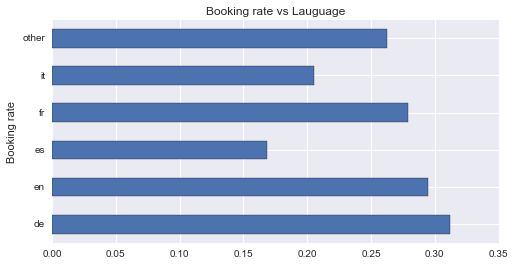

In [84]:
group_by_language = contact_listing_user.groupby('dim_language_cat')['converted'].mean()

group_by_language.plot(kind='barh', figsize=(8, 4), title='Booking rate vs Lauguage')
plt.ylabel('Booking rate')

As above, German speaking users show the highest booking rate, while Spanish and Italian speaking users have the lowest. Then look at the country. Clearly Spain and Italy is under performing. It could be due to poorly translated website. Perhaps it doesn't fit the local culture, and some payment issue. Given how many users are based in Spain(2nd largest), fixing this should be a top priority. 

In [85]:
#distribution
contact_listing_user.dim_country.value_counts().head(10)

ES    13611
US     7796
FR     4215
GB     2836
IT     2094
DE     1967
AR     1422
AU     1377
RU     1236
CA     1216
Name: dim_country, dtype: int64

In [86]:
#check missing values
contact_listing_user.dim_country.isnull().sum()

9

In [87]:
#fill with the mode
contact_listing_user.dim_country.fillna('ES', inplace=True)

In [88]:
#look at the top 5 country
cols_country = ['ES', 'US', 'FR', 'GB', 'IT']
contact_listing_user['dim_country_cat'] = contact_listing_user['dim_country']\
                                    .apply(lambda x: x if x in cols_country else 'other')
#contact_listing_user.dim_country.value_counts()

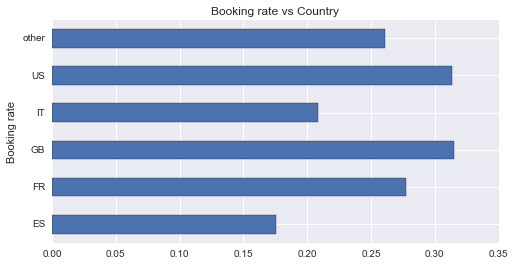

In [89]:
#plot booking rate change as country
group_by_country = contact_listing_user.groupby('dim_country_cat')['converted'].mean()

group_by_country.plot(kind='barh', figsize=(8, 4), title='Booking rate vs Country')
plt.ylabel('Booking rate')

The above shows that Spain and Italy have relatively low booking rate, while German and US have the highest. This is consistant with the language vs booking rate trend. I will use country in the model building.

In [90]:
user.ts_first_verified.value_counts().head()

-unknown-              20267
2013-10-26 11:56:51        2
2013-11-14 08:04:29        2
2013-11-16 10:19:55        2
2013-11-14 14:05:08        2
Name: ts_first_verified, dtype: int64

Too many unknown. I will not consider it in the model.

## 2. Predict booking rate
I will model contact me and book it separately.

### 1. Prepare train and test sets

In [91]:
#remind features
contact_listing_user.columns

Index([u'id_guest_anon', u'id_host_anon', u'id_listing_anon',
       u'ts_interaction_first', u'ts_reply_at_first', u'ts_accepted_at_first',
       u'ts_booking_at', u'ds_checkin_first', u'ds_checkout_first',
       u'm_guests_first', u'm_interactions',
       u'm_first_message_length_in_characters', u'dim_contact_channel_first',
       u'delay_reply_nday', u'delay_checkin_nday', u'converted',
       u'checkin_month', u'inquiry_checkin', u'inquiry_checkin_cat',
       u'num_interactions_cat', u'inquiry_reply_cat', u'dim_room_type',
       u'dim_person_capacity', u'dim_bathrooms', u'dim_total_reviews',
       u'enough_capacity', u'review_cat', u'bathroom_cat', u'id_user_anon',
       u'dim_language', u'dim_country', u'ts_first_verified',
       u'dim_language_cat', u'dim_country_cat'],
      dtype='object')

In [92]:
#categorical and numerical features of interest
cate = ['dim_contact_channel_first', 'dim_room_type', 'dim_country_cat']
num = ['m_first_message_length_in_characters', 'checkin_month', 'enough_capacity', \
       'dim_bathrooms', 'dim_total_reviews', 'delay_reply_nday', 'm_interactions', \
       'inquiry_checkin']

In [93]:
test = contact_listing_user[num + cate]
#test.columns

In [94]:
#contact me
test_contact_me = test[test.dim_contact_channel_first == 'contact_me']

#book it
test_book_it = test[test.dim_contact_channel_first == 'book_it']

In [95]:
#dummify categorical features
def dummify_data_frame(data):
    for col in cate:
        dummy = pd.get_dummies(data[col])
        data = pd.concat([data, dummy], axis = 1)
        data = data.drop(col, axis = 1)
    return data

In [96]:
#prepare data for contact me and book it
X_contact_me = dummify_data_frame(test_contact_me)
X_contact_me.drop('contact_me', inplace=True, axis=1)
X_book_it = dummify_data_frame(test_book_it)
X_book_it.drop('book_it', inplace=True, axis=1)

#booking rate
y_contact_me = contact_listing_user[contact_listing_user.dim_contact_channel_first == 'contact_me'].converted
y_book_it = contact_listing_user[contact_listing_user.dim_contact_channel_first == 'book_it'].converted

### 2. Model building
I will use random forest model here. The reasons are:
1. RF is easy to use and is fast.
2. RF deals with missing values and categorical features. (Although I've taken care the missing values already)

In [97]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import recall_score, precision_score, f1_score, roc_curve, auc, confusion_matrix

Booking rate is highly imbalanced. I will use class_weight parameter in RF.

In [98]:
#check ratio
y_contact_me.value_counts()

0    35100
1     5890
Name: converted, dtype: int64

In [99]:
#check ratio
y_book_it.value_counts()

1    5242
0    2474
Name: converted, dtype: int64

In [100]:
#build RF model
def rf_model(X, y, weight_ratio):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    rf = RandomForestClassifier(n_estimators = 100, random_state = 42, class_weight = {0: 1, 1: weight_ratio})
    solution = rf.fit(X_train, y_train)
    feature_importance = pd.DataFrame({'features': X_train.columns,'importance': solution.feature_importances_})
    feature_importance.sort_values(by = 'importance', ascending = False, inplace=True)
    feature_importance.set_index('features').plot(kind='barh', figsize=(12, 6))
    plt.xlim([0, 0.35])
    return rf, solution, X_test, y_test

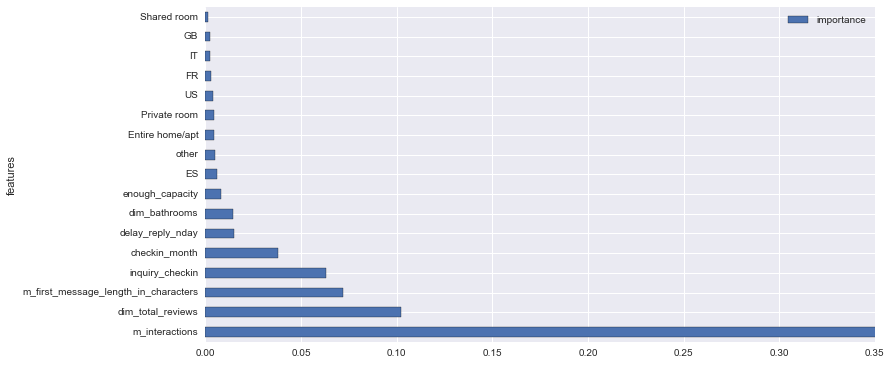

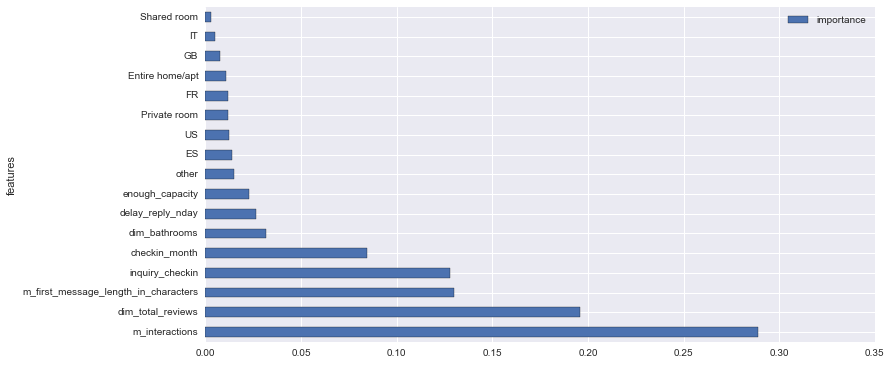

In [101]:
#plot feature importance
rf_contact_me, solution_contact_me, X_test_contact_me, y_test_contact_me = rf_model(X_contact_me, y_contact_me, 6)
rf_book_it, solution_book_it, X_test_book_it, y_test_book_it  = rf_model(X_book_it, y_book_it, 2)

The number of guest-host interactions is the most important indicator of booking rate. Unfortunatley, it is probably the least "actionable". Guests interact with hosts because they already want to book. 

I will rebuild the RF without the variable. Before that, let's look at the model performance. I will take a look at the ROC curve and cross validation. 

In [102]:
def ROC(solution, X_test, y_test):
    y_pred = solution.predict_proba(X_test)
    y_scores = pd.DataFrame(y_pred)[1]
    fpr, tpr, thresholds = roc_curve(y_test.ravel(), y_scores.ravel())
    auc_score = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, linestyle = ':', linewidth = 4, color = 'navy', \
             label='ROC curve (area = %.4s)' % auc_score)
    plt.plot([0, 1], [0, 1], 'k--', lw = 2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend('Receiving Operating Characteristic')
    plt.legend(loc = 'lower right')

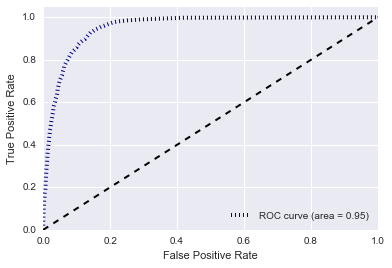

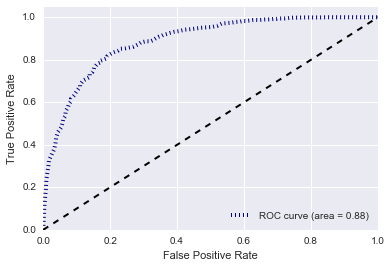

In [103]:
ROC(solution_contact_me, X_test_contact_me, y_test_contact_me)
ROC(solution_book_it, X_test_book_it, y_test_book_it)

Based on the ROC, if we care about minimizing false positive, we would choose a cut-off that would give us true positive rate of ~0.5 and false positive rate almost zero. However, if we care about maximizing true positive, we will have to decrease the cut-off. This way we will classify more events as '1'. There will be many false positives. 

In [104]:
def cross_validation(clf, X, y):
    score = cross_val_score(clf, X, y, cv = 3).mean()
    return score
score_contact_me = cross_validation(rf_contact_me, X_contact_me, y_contact_me)
score_book_it = cross_validation(rf_book_it, X_book_it, y_book_it)

In [105]:
print 'Through contact me method, the 3 fold cross validation score is %.2f' % score_contact_me
print 'Through book it method, the 3 fold cross validation score is %.2f' % score_book_it

Through contact me method, the 3 fold cross validation score is 0.92
Through book it method, the 3 fold cross validation score is 0.83


Due to imbalanced data, if all data are predicted "not booked", we would get a ~85% in contact me category. Cross validation score of 0.92 shows that the model does increase the predicting power. 

Let's rebuild the RF model. Since classes are heavily unbalanced and I dont' have that very powerful variable anymore, I will change the weight a bit, just to make sure I will get something classified as 1. Since guest country and room type are not important indicators, I will remove them and focus on the important ones.

In [106]:
X_contact_me = pd.concat([X_contact_me.loc[:, :'delay_reply_nday'], \
                          X_contact_me.loc[:, 'inquiry_checkin']], axis=1)
X_book_it = pd.concat([X_book_it.loc[:, :'delay_reply_nday'], \
                       X_book_it.loc[:, 'inquiry_checkin']], axis=1)

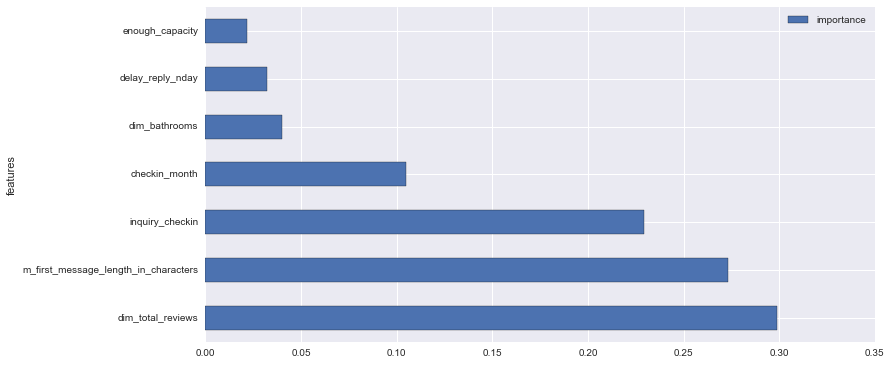

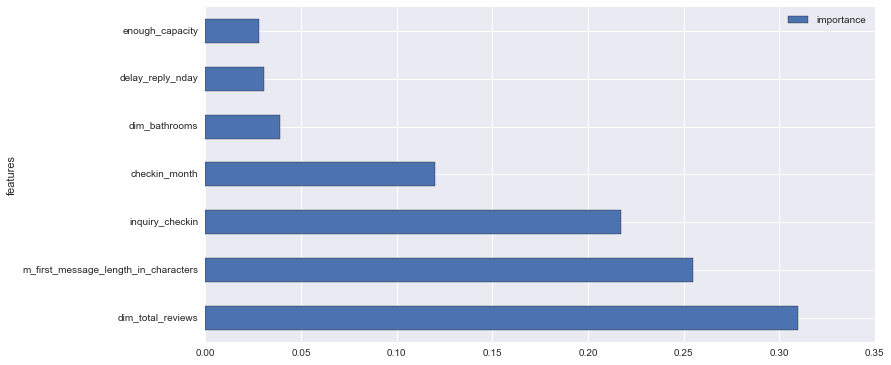

In [107]:
rf_contact_me, solution_contact_me, X_test_contact_me, y_test_contact_me = rf_model(X_contact_me, y_contact_me, 8)
rf_book_it, solution_book_it, X_test_book_it, y_test_book_it  = rf_model(X_book_it, y_book_it, 4)

The feature importance plots show that:
1. More reviews are better! 
2. A personal inquiry message helps connect with the host
3. The earlier you book, the higher chance of successful booking
4. Consider seasonality
5. Bathroom number matters. This is likely an indicator of the room price. 
6. Quick reply from the host(within a day)  
7. Make sure the room is large enough to hold all the guests

Suggestions:
1. Recommend guest leave reviews. Airbnb can promote this by giving coupon or discount. Or marketing team can reach out to guest through email and remind them to leave the review.
2. Encourage guest write personal message to connect with the host.
3. Book ahead, especially during busy season. Tell marketing to start before busy season starts so that potential travellers can plan early.
4. Set up reminder to host to reply guests' messages. 
5. Spain and Italy are underperforming. It could be due to poorly translated website. Perhaps it doesn't fit the local culture, and some payment issue. Given how many users are based in Spain(2nd largest), fixing this should be a top priority. 

## 3. Given more time, I'd like to look at ...

1. Booking rate can be treated as two processes. One is the rate that the host accepts the request. The other is the guest booked rate conditioned on host accepting the request. I'd like to build two separate models for the two rate, and find factors that improve them, respectively.
2. Optimize the random forest model. This includes the number of trees, max feature numbers and etc. 
3. Try other classification methods, such as logistic regression, SVM. I'd like to compare the models, find the best performer or build an ensemble model. 

    alpha
